#### Train different classifiers on still image datasets and visualize their outputs/performance

PARAMETERS
* detection confidence  -  check from realtime detection
* tracking confidence  -  check from realtime detection
* presence confidence  -  check from realtime detection
* CLASSIFIER: random forest - n_estimators

class balancing or classifier does not do much - seems to be a matter of the
kyepoint detection

In [21]:
import numpy as np
import mediapipe as mp
import pickle
from prepare_data import parse_image_folder
from extract_features import *
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import cv2

seed = 333

In [85]:
# from the Gemini API

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

def draw_landmarks_on_image(rgb_image, detection_result=None, landmark_coords=None):
    """Can take in the landmark result object from MP detector or 
    the coordinates directly as an array (landmark, xyz coords)"""
    
    annotated_image = np.copy(rgb_image)

    # can also give the coords directly after processing
    if landmark_coords is not None:
        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark_coords[i,0], y=landmark_coords[i,1], z=landmark_coords[i,2]) for i in range(landmark_coords.shape[0])
        ])
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          pose_landmarks_proto,
          solutions.pose.POSE_CONNECTIONS,
          solutions.drawing_styles.get_default_pose_landmarks_style())
        return annotated_image
    
    pose_landmarks_list = detection_result.pose_landmarks

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx] 
        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          pose_landmarks_proto,
          solutions.pose.POSE_CONNECTIONS,
          solutions.drawing_styles.get_default_pose_landmarks_style())
        
    return annotated_image

In [3]:
# still image dataset path
directory = "/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/image_data"

# get standardized images and labels
X, labels, df = parse_image_folder(directory)

print('Number of images:', len(X))

Number of images: 2754


In [137]:
# extract landmarks: MEDIAPIPE 
min_pose_detection_confidence = 0.7  # biggest effect
min_pose_presence_confidence = 0.5
min_tracking_confidence = 0.5

mp_model_path = "../pretrained_models/pose_landmarker_full.task"
detector = mediapipe_detector(mp_model_path,
                              min_pose_detection_confidence=min_pose_detection_confidence,
                              min_pose_presence_confidence=min_pose_presence_confidence,
                              min_tracking_confidence=min_tracking_confidence,)

x_data = np.zeros((len(X), MP_N_LANDMARKS * 4))  # For pose landmarks
y_data = np.zeros(labels.shape)  # For labels

c = 0

# run inference on every image
for i in range(len(X)):
    landmarks = mediapipe_detect(detector, X[i])
    # only include images with detected landmarks
    if landmarks is not None:
        # with detected poses
        if len(landmarks.pose_landmarks) != 0:
            x_data[i], y_data[i] = mediapipe_format_landmark(landmarks, labels[i])
            
            # draw one example detection
            if c < 1000:
                annotated_image = draw_landmarks_on_image(X[i], landmarks)
                cv2.imwrite(f'visualize_landmarks_mediapipe/{i}.jpg', cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))     
                c += 1      
                
# # drop images without detected poses
# non_zero_mask = np.any(x_data != 0, axis=(1,))
# x_data = x_data[non_zero_mask]
# y_data = y_data[y_data != 0]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, shuffle=True, random_state=seed
)
print('Number of training samples:', len(X_train))

I0000 00:00:1733805291.688353 63656735 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Number of training samples: 2203


In [ ]:
# extract landmarks: movenet



In [121]:
# recover the indices
x_data_index = np.arange(len(x_data), dtype=int)
y_data_index = np.arange(len(y_data), dtype=int)

index_train, index_test, index_train, index_test = train_test_split(
    x_data_index, y_data_index, test_size=0.2, shuffle=True, random_state=seed
)

In [122]:
# save the landmark training datasets

with open(f'landmark_datasets/landmark_train_DROP_256_{min_pose_detection_confidence}_{min_pose_presence_confidence}_{min_tracking_confidence}.pkl', 'wb') as f:
    pickle.dump([X_train, y_train], f)
    
with open(f'landmark_datasets/landmark_test_DROP_256_{min_pose_detection_confidence}_{min_pose_presence_confidence}_{min_tracking_confidence}.pkl', 'wb') as f:
    pickle.dump([X_test, y_test], f)

In [139]:
# class balancing - somehow did not work when the confidence > 0.8?? 
# would not accept neighbors > 1
smote_k_neighbors = 1 
smote = SMOTE(random_state=seed, k_neighbors=smote_k_neighbors, sampling_strategy='not majority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# save class distributions before and after rebalancing
y_before_rebalance = pd.Series(y_train).value_counts()
y_after_rebalance = pd.Series(y_resampled).value_counts()
with open(f'rebalancing_analysis/SMOTE_{smote_k_neighbors}.pkl', 'wb') as f:
    pickle.dump((y_before_rebalance, y_after_rebalance), f)
    
print('Number of training samples after SMOTE:', len(X_resampled))

# save the rebalanced data
with open(f'landmark_datasets/landmark_train_resampled_256_DROP_{min_pose_detection_confidence}_{min_pose_presence_confidence}_{min_tracking_confidence}.pkl', 'wb') as f:
    pickle.dump([X_resampled, y_resampled], f)


Number of training samples after SMOTE: 45024


In [124]:
# train neural net based on best for train but with more regularization
# # the key was alpha not too high but also not too low
# from sklearn.neural_network import MLPClassifier

# # with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/training_pipeline/landmark_datasets/landmark_train_256_0.9_0.8_0.8.pkl', 'rb') as f:
# #     X_resampled, y_resampled = pickle.load(f)

# nn = MLPClassifier(random_state=seed, max_iter=2000, learning_rate='adaptive', alpha=0.01, learning_rate_init=0.001, hidden_layer_sizes=(128, 128))

# # plot the loss and train
# nn.fit(X_resampled, y_resampled)

# # save the model
# with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/trained_classifiers/drop_neural_network_best.pkl', 'wb') as f:
#     pickle.dump(nn, f)

# # train a random forest classifier
# rf = RandomForestClassifier(random_state=seed, n_estimators=200, max_depth=10)

# # plot the loss and train
# rf.fit(X_resampled, y_resampled)

# # save the model
# with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/trained_classifiers/randomforest3.pkl', 'wb') as f:
#     pickle.dump(rf, f)

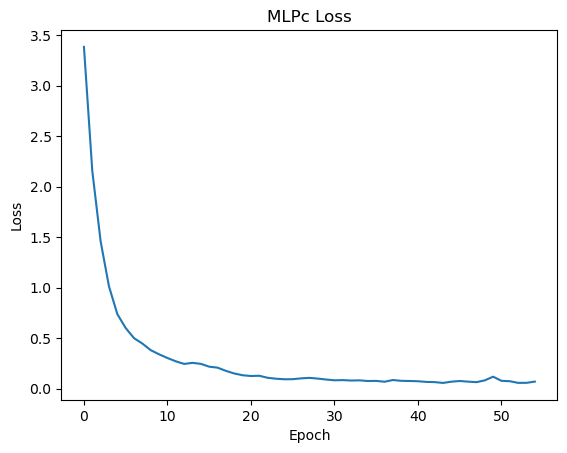

In [135]:
# load optimized model
with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/trained_classifiers/FINALneural_network_best.pkl', 'rb') as f:
    nn = pickle.load(f)
    
# plot the loss
import matplotlib.pyplot as plt
plt.plot(nn.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLPc Loss')
plt.show()


In [138]:
# save the FINAL clasifier
# with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/trained_classifiers/FINALneural_network_best.pkl', 'wb') as f:
#     pickle.dump(nn, f)
    
y_pred = nn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision=precision_score(y_test, y_pred, average='macro')
recall=recall_score(y_test, y_pred, average='macro')

print(f"Accuracy {accuracy}, F1 {f1}", f"Precision {precision}, Recall {recall}")


Accuracy 0.4627949183303085, F1 0.6854725645911747 Precision 0.7106656364468865, Recall 0.7295027599715102


/Users/alejandraduran/opt/anaconda3/envs/cos429/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alejandraduran/opt/anaconda3/envs/cos429/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# metrics to evaluate how the model is doing in multiclass class

# get the images again
X_images, labels, df = parse_image_folder(directory)

In [115]:
# Assuming index_test is your array of indices
index_test = np.array(index_test, dtype=int)
# Ensure it is 1-dimensional
index_test = index_test.flatten()
# Assuming X_images is a list and index_test is your array of indices
X_images = np.array(X_images)
# get the test images from the split
X_images_test = X_images[index_test]

# visualize 10 correct labeled images
correct = np.where(y_test == y_pred)[0]
for i in correct[:10]:
    # pass in the landmark coordinates as (landmark, xyz(v) coords)
    annotated_image = draw_landmarks_on_image(X_images_test[i], landmark_coords=X_test[i].reshape(-1, 4))
    cv2.imwrite(f'correct_predictions/{i}.jpg', cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))  
    
# visualize 10 incorrect labeled images
incorrect = np.where(y_test != y_pred)[0]
for i in incorrect[:10]:
    annotated_image = draw_landmarks_on_image(X_images_test[i], landmark_coords=X_test[i].reshape(-1, 4))
    cv2.imwrite(f'incorrect_predictions/{i}.jpg', cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))   